# COCO object detection

In [33]:
# things to try
# - different learning rates (slices)
# - normalize data
# - add some metric - mAP (mean average precision)
# - resnet 50
# - try with Pascal dataset
# - more boxes, scales, focal loss
# - try retina net

In [34]:
# Lesson 2: tips for choosing learning rates
# choosing learning rate: beginning of the long steep downwards slope in LR finder
# valid loss out of whack - learning rate too high
# valid loss lower than training loss - learning rate too low or too few epochs
# 3e-3 is a good learning rate most of the time
# after unfreeze: slice(<whatever comes out of lr finder>, <initial lr/10>)
# Lesson 3: data classes explanation
# at 28:09 - an alternative example of object detection databunch creation

In [35]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [36]:
from fastai.vision import *
from fastai.core import *
import json
from collections import defaultdict
import pdb
import numpy as np

## Data

In [37]:
coco = untar_data(URLs.COCO_SAMPLE)

img_dir = coco/'train_sample'
annotations = coco/'annotations'/'train_sample.json'

#image size
sz = 224

with open(annotations) as f:
    train_json = json.load(f)
ncat = len(train_json['categories'])

images, lbl_bbox = get_annotations(annotations)

img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct(valid_pct=0.1, seed=0)                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), size=sz, tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=8, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

In [38]:
#data.show_batch(rows=3, ds_type=DatasetType.Valid, figsize=(10,10))

## Model

In [39]:
class StdConv(nn.Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

class OutConv(nn.Module):
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1) # first bboxes
        self.oconv2 = nn.Conv2d(nin, (ncat+1)*k, 3, padding=1) # than class labels
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

class SSD_Head(nn.Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv2 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv2(x)
        return self.out(x)

## Loss

In [40]:
# centre+height/width -> corners
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

def create_anchors(ncells=4, k=1):
    # create a tensor with anchor boxes - middles + sizes
    # coordinates of bboxes are scaled to -1,1, so anchor boxes must be too
    # ncells - ncells in a grid dimension
    # k - num boxes per cell
    first_ctr = -1 + 2/(2*ncells)
    last_ctr  =  1 - 2/(2*ncells)
    a_x = np.repeat(np.linspace(first_ctr, last_ctr, ncells), ncells)
    a_y = np.tile(np.linspace(first_ctr, last_ctr, ncells), ncells)
    a_sz = np.array([2/ncells for _ in a_x])
    anchors = torch.tensor(np.stack([a_x, a_y, a_sz, a_sz], axis=1)).type(torch.FloatTensor).cuda()
    anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:]) # anchor boxes corners
    grid_sizes = torch.tensor(np.array([2/ncells]), requires_grad=False).type(torch.FloatTensor).unsqueeze(1).cuda()
    return anchors, anchor_cnr, grid_sizes


In [41]:
anchors, anchor_cnr, grid_sizes = create_anchors()

In [42]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def actn_to_bb(actn, anchors):
    actn_bbs = torch.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

In [43]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def forward(self, pred, targ):
        t = one_hot_embedding(targ, self.num_classes+1)
#         t = t[:,:-1].contiguous().cuda()
#         x = pred[:,:-1]
        # in fastai v1, the background is encoded as the first class, rather than the last one
        t = t[:,1:].contiguous().cuda()
        x = pred[:,1:]
        w = self.get_weight(x,t)
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False)/self.num_classes
    
    def get_weight(self,x,t): return None

loss_f = BCE_Loss(ncat)

In [44]:
# remove padding - images in a minibatch will have a different number of objects
# those with fewer objects will have their bbox groundtruth tensor padded with 0s
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)
    bb_keep = ((bbox[:,2]-bbox[:,0])>0).nonzero()[:,0]
    return bbox[bb_keep],clas[bb_keep]

def ssd_1_loss(pred_bbox,pred_clas,bbox,clas):
    bbox,clas = get_y(bbox,clas)
    if len(bbox) == 0 and len(clas) == 0:
        return 0.0, 0.0
    a_ic = actn_to_bb(pred_bbox, anchors)
    overlaps = jaccard(bbox.data, anchor_cnr.data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,False)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[~pos] = 0 # background coded as 0
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(pred_clas, gt_clas)
    return loc_loss, clas_loss

def ssd_loss(pred,targ_bb,targ_c):
    lcs,lls = 0.,0.
    for pr_bb, pr_c, ta_bb, ta_c in zip(*pred, targ_bb, targ_c):
        loc_loss, clas_loss = ssd_1_loss(pr_bb, pr_c, ta_bb, ta_c)
        lls += loc_loss
        lcs += clas_loss
#    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return 30*lls+lcs

## Train

In [45]:
head_reg4 = SSD_Head(k=1, bias=-3.)
learn = cnn_learner(data, models.resnet34, loss_func=ssd_loss, custom_head=head_reg4)

/home/gosia/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


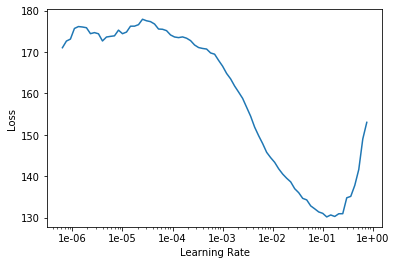

In [46]:
lr_find(learn)
learn.recorder.plot()

In [47]:
lr=1e-3
learn.fit_one_cycle(3, lr)

In [48]:
learn.save('stage1-1e-3')

In [ ]:
#learn.load('better-model-lr-3e-4')

In [ ]:
learn.summary()

In [66]:
def corners2hw(corners): return torch.cat([corners[:,:2], corners[:,2:] - corners[:,:2]], dim=1)
def show_results(max_show=0, printit=False):
    if max_show == 0:
        max_show = len(data.valid_ds)
    else:
        max_show = min(max_show, len(data.valid_ds))
    figsize = (10, max_show*5)
    fig,axs = plt.subplots(max_show, 2, figsize=figsize)
    i = 0
    while i < max_show:
        img, label = data.train_ds[i]
        img.show(ax=axs[i,0], y=label, figsize=(5,5))        
        x, y = data.one_item(img)
        pred_bb, pred_cc = learn.model(x)
        pred_cc = pred_cc.squeeze() # remove the singleton batch dimension
        pred_bb = pred_bb.squeeze()
        pred_clas = pred_cc.max(1)[1] # get the index of the max as the predicted clas
        pred_clas_prob = pred_cc.max(1)[0].sigmoid() # get the sigmoid of the max as the class probability
        pos_idx = pred_clas > 0
#         if i == 1:
#             pdb.set_trace()
        a_ic = actn_to_bb(pred_bb, anchors)
        anc_cnr = anchor_cnr.clone()
        if printit:
            print(f"i={i}, a_ic orig")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor orig")
            print(anc_cnr[pos_idx])
        h = 224
        w = 224
        # convert to image coordinates (add 1 and scale by img size)
        a_ic.add_(1)
        anc_cnr.add_(1)
        if printit:
            print(f"i={i}, a_ic moved")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor moved")
            print(anc_cnr[pos_idx])        
        a_ic.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        anc_cnr.mul_(torch.tensor([h/2, w/2, h/2, w/2]).cuda()).long()
        if printit:
            print(f"i={i}, a_ic rescaled")
            print(a_ic[pos_idx])
            print(f"i={i}, anchor rescaled")
            print(anc_cnr[pos_idx])
        # select only bboxes that detect something else than background (0)
        pos_pred_clas = pred_clas[pos_idx]
        pos_a_ic = a_ic[pos_idx]
        if len(pos_pred_clas) > 0:
#             if i == 1:
#                 pdb.set_trace()
            pred_label = ImageBBox.create(224, 224, pos_a_ic.cpu(), pos_pred_clas.cpu(), data.train_ds.y.classes)
            img.show(ax=axs[i,1], y=pred_label, figsize=(5,5))
        else:
            img.show(ax=axs[i,1], figsize= (5,5))
        i = i+1
        

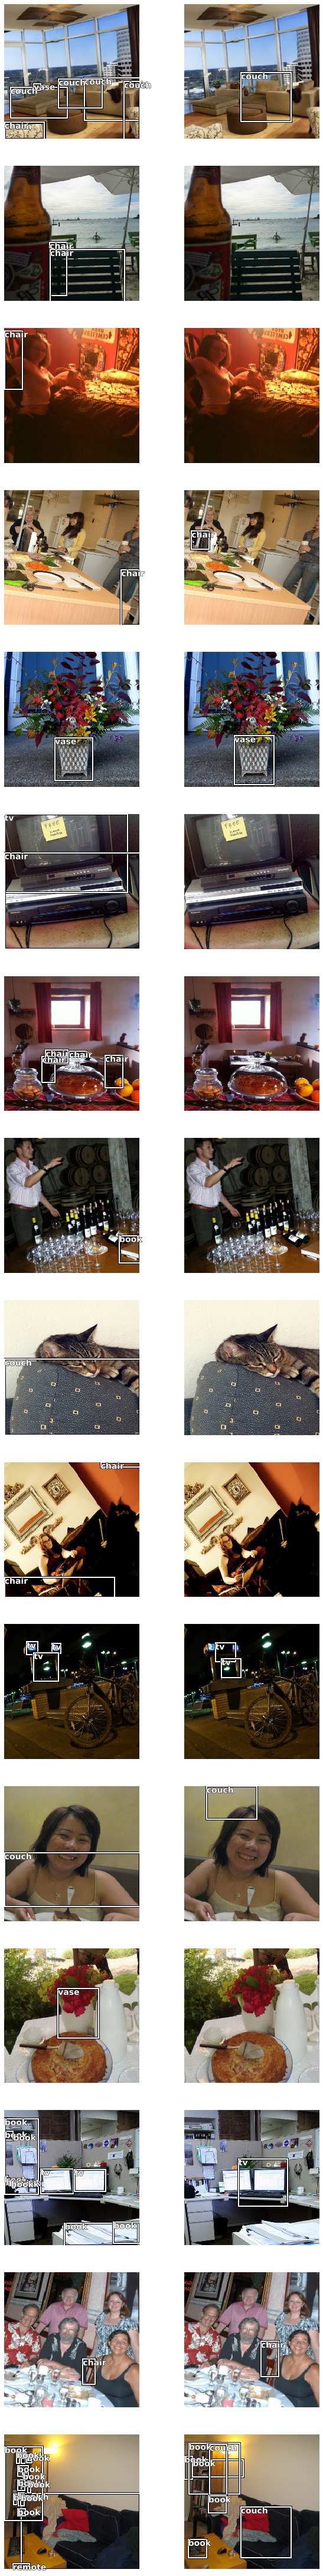

In [67]:
show_results(max_show=16, printit=False)

In [59]:
learn.load('stage1-1e-3');

/home/gosia/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


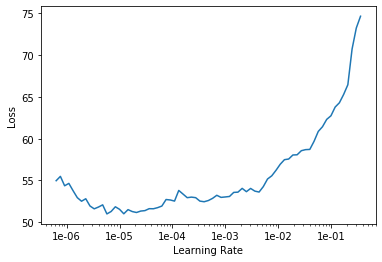

In [60]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [62]:
lr=slice(1e-6, 3e-4)
learn.fit_one_cycle(10, lr)

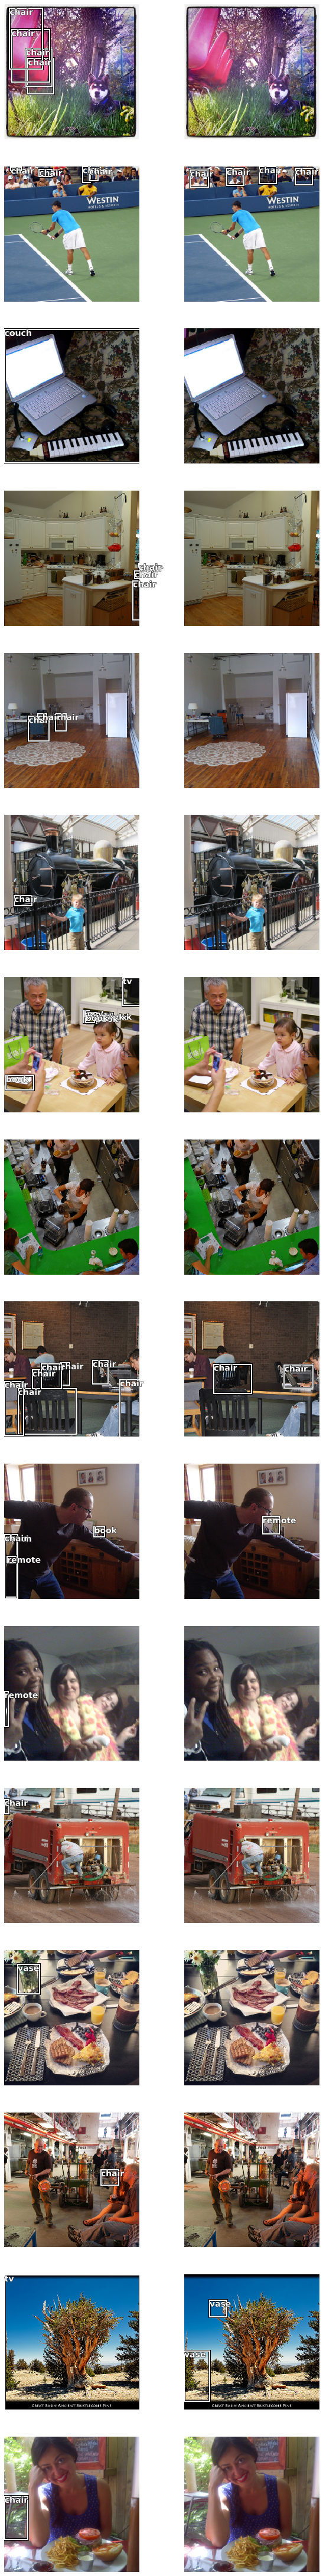

In [63]:
show_results(max_show=16, printit=False)

In [64]:
learn.save('stage2-1e-3')

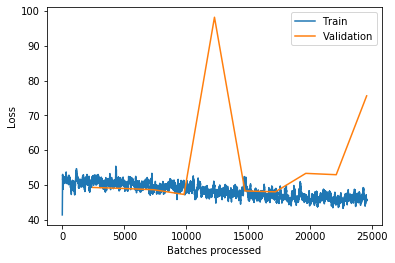

In [65]:
learn.recorder.plot_losses()